In [1]:
import sys
import os

prj_path = "/Users/darien/Library/Mobile Documents/com~apple~CloudDocs/Code/QuantTrading/TradingProject/TradingLibADS"
sys.path.append(prj_path)

from utils.data_downloader import DataUtils
import utils.analyser as an
import utils.stock_visualizer as sv
import numpy as np

In [26]:
import datetime
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import coint, adfuller

sys.path.insert(0, '../..')
sys.path.insert(0, '../../utils')

%load_ext autoreload
%autoreload 2
%precision %.5f
warnings.filterwarnings('ignore')

plt.style.use('qb_dark')
pio.templates.default = "darien_dark"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Pull in Ranked Pairs by Correlation & Co-integration for Selection


In [4]:
pairs_path = "../data/ranked_pairs_snp.csv"

pairs_df = pd.read_csv(pairs_path)
pairs_df.head(10)

,agg_rank,ticker_0,ticker_1,corr,cointeg_pval
0,0,GS,BLK,0.8344,0.0160
1,1,JPM,CRM,0.8390,0.0265
2,2,INTC,C,0.8583,0.1598
3,3,WFC,UNP,0.7002,0.0293
4,4,HON,GS,0.6692,0.0188
5,5,HON,BLK,0.8017,0.2085
6,6,JPM,GS,0.7291,0.1579
7,7,WFC,AXP,0.7783,0.2241
8,8,WFC,GS,0.7102,0.1923
9,9,HON,C,0.7518,0.2875


Select Sample Pair


In [12]:
pair = pairs_df.iloc[0]
ticker_0 = pair["ticker_0"]
ticker_1 = pair["ticker_1"]
start_date = "2021-01-01"
end_date = "2024-03-31"
dl = DataUtils(verbose=False)
data = dl.get_data([ticker_0, ticker_1], start_date, end_date)
data

Pulled ['Close'] for ['GS', 'BLK'] from 2021-01-01 to 2024-03-31

Ticker,BLK,GS
Date,,
2021-01-04,710.820007,265.000000
2021-01-05,714.580017,270.929993
2021-01-06,734.960022,285.549988
2021-01-07,750.419983,291.649994
2021-01-08,756.450012,290.079987
...,...,...
2024-03-22,824.830017,406.820007
2024-03-25,816.210022,404.940002
2024-03-26,820.200012,406.179993


In [54]:
# Make Stationary
s1 = data[ticker_0]
s2 = data[ticker_1]

display(an.check_stationarity(s1), an.check_stationarity(s2))

s1_diff = an.transform_to_stationary(s1)
s2_diff = an.transform_to_stationary(s2)

display(an.check_stationarity(s1_diff), an.check_stationarity(s2_diff))

# Calculate the spread
spread = s1_diff - s2_diff


# Check stationarity of the spread
display(an.check_stationarity(spread))
spread

0.06343

0.43073

0.00000

0.00000

0.00000

Date
2021-01-05     2.169983
2021-01-06    -5.760010
2021-01-07    -9.359955
2021-01-08    -7.600037
2021-01-11    -6.479980
                ...    
2024-03-22    10.339996
2024-03-25     6.739990
2024-03-26    -2.750000
2024-03-27    -5.849976
2024-03-28     3.859985
Length: 813, dtype: float64

In [ ]:
/Users/darien/Library/Mobile Documents/com~apple~CloudDocs/Code/QuantTrading/TradingProject/TradingLibADS/strategies/Notebooks/spread_forecasting.ipynb

In [52]:
import numpy as np
import pandas as pd


print("Data type of spread:", spread.dtype)


print("Missing values in spread:", spread.isnull().any())


spread.dropna(inplace=True)


features = pd.DataFrame(index=spread.index)


lags = [1, 2, 3, 5, 7, 10]
for lag in lags:
    features[f"lag_{lag}"] = spread.shift(lag)


window_sizes = [5, 10, 20, 50]
for window in window_sizes:
    features[f"ma_{window}"] = spread.rolling(window=window).mean()


ema_spans = [5, 10, 20, 50]
for span in ema_spans:
    features[f"ema_{span}"] = spread.ewm(span=span).mean()


features.dropna(inplace=True)


print(features.head())

Data type of spread: float64
Missing values in spread: False
               lag_1     lag_2      lag_3      lag_5      lag_7     lag_10  \
Date                                                                         
2021-03-17 -8.399994 -5.580017  12.639984   4.929993  10.140015  18.309998   
2021-03-18 -1.909943 -8.399994  -5.580017   6.460022 -26.639984  13.139984   
2021-03-19  7.539978 -1.909943  -8.399994  12.639984   4.929993 -20.990021   
2021-03-22 -9.710022  7.539978  -1.909943  -5.580017   6.460022  10.140015   
2021-03-23 -6.149994 -9.710022   7.539978  -8.399994  12.639984 -26.639984   

                ma_5     ma_10     ma_20     ma_50     ema_5    ema_10  \
Date                                                                     
2021-03-17  0.642010 -1.620996  1.269003  1.251001 -2.084467 -0.992867   
2021-03-18  0.858002 -2.180997  0.895003  1.358401  1.123681  0.558615   
2021-03-19 -3.612000 -1.052997  0.452499  1.279401 -2.487553 -1.308465   
2021-03-22 -3.725995 -

## Generate Features


In [71]:
import numpy as np
import pandas as pd


features = pd.DataFrame(index=spread.index)
spread.dropna(inplace=True)


lags = [1, 2, 3, 5, 7, 10]
for lag in lags:
    features[f"lag_{lag}"] = spread.shift(lag)


spread.dropna(inplace=True)


features = pd.DataFrame(index=spread.index)

features["spread"] = spread
window_sizes = [5, 10, 20, 50]
for window in window_sizes:
    features[f"ma_{window}"] = spread.rolling(window=window).mean()

ema_spans = [5, 10, 20, 50]
for span in ema_spans:
    features[f"ema_{span}"] = spread.ewm(span=span).mean()

features["volatility"] = spread.rolling(window=10).std()
features["volatility_ratio"] = features["volatility"] / spread.rolling(window=50).std()


features["pct_change"] = spread.pct_change()
features["diff"] = spread.diff()
features["log_return"] = np.log(spread) - np.log(spread.shift(1))

momentum_window = 5
features["momentum"] = spread.diff(momentum_window)
trend_window = 10
features["trend"] = spread.rolling(window=trend_window).mean() - spread.shift(
    trend_window
)


features.dropna(inplace=True)

features.head(10)


# Calculate the split date (6 months ago)
split_date = pd.Timestamp.now() - pd.DateOffset(months=6)

# Create train and test sets based on the split date
train_data = features[features.index < split_date]
test_data = features[features.index >= split_date]

# Print the shapes of the train and test sets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Display the first few rows of the train and test sets
print("Train data:")
display(train_data.head())
print("\nTest data:")
test_data.head()

Train data shape: (160, 16)
Test data shape: (25, 16)
Train data:


,spread,ma_5,ma_10,ma_20,ma_50,ema_5,ema_10,ema_20,ema_50,volatility,volatility_ratio,pct_change,diff,log_return,momentum,trend
Date,,,,,,,,,,,,,,,,
2021-04-13,1.329987,-4.031995,-4.268002,-5.092499,-0.894400,-2.449012,-4.033236,-4.022625,-2.316793,10.272834,0.944545,-0.050005,-0.070007,-0.051299,-4.500000,-1.648038
2021-04-14,9.089996,-0.853998,-4.847000,-4.217999,-0.545601,1.397324,-1.647192,-2.772552,-1.839255,9.178591,0.841180,5.834653,7.760010,1.922006,15.889984,-19.726974
2021-04-19,1.139984,1.627991,-0.752002,-4.128001,-0.586000,1.039202,-0.836640,-2.127727,-1.686794,8.019731,0.722070,-0.887687,-9.010040,-2.186462,-0.260010,20.538007
2021-04-28,5.709961,1.617999,-0.245004,-2.546002,-0.996401,1.587994,0.390858,-0.864933,-1.222003,8.059671,0.720627,5.206389,4.789948,1.825579,8.889984,-9.335001
2021-05-11,4.590057,0.482007,-1.029996,-0.468498,-1.897999,2.604320,0.398729,-0.796606,-1.273911,7.809159,0.727198,-0.676072,-9.579926,-1.127233,15.720062,-1.950009



Test data:


,spread,ma_5,ma_10,ma_20,ma_50,ema_5,ema_10,ema_20,ema_50,volatility,volatility_ratio,pct_change,diff,log_return,momentum,trend
Date,,,,,,,,,,,,,,,,
2023-10-10,3.829987,-1.566010,-0.428006,1.963000,1.115999,0.942548,0.573978,0.863924,0.806430,4.599646,0.855727,-0.197066,-0.940002,-0.219483,-1.360016,-6.238034
2023-10-13,7.959991,3.484003,0.456000,1.825499,0.773000,3.306686,1.956391,1.492323,1.063439,5.357534,1.038887,1.390376,4.629974,0.871450,13.940002,3.336005
2023-10-25,1.290039,0.562006,1.773001,0.476001,0.573801,1.548147,1.401607,1.257523,1.023343,6.506520,1.254537,-0.439103,-1.009918,-0.578218,-10.719940,4.242972
2023-10-26,1.839966,2.647998,1.623996,0.497998,0.661000,1.645420,1.481309,1.312993,1.055368,6.483924,1.254158,0.426287,0.549927,0.355074,10.429962,-1.706021
2023-10-27,1.910004,1.322003,1.018997,0.737498,0.766200,1.733615,1.559253,1.369852,1.088883,6.097797,1.186322,0.038065,0.070038,0.037358,-6.629974,-6.940994


### Arima Model


In [74]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression


train_data_reg = train_data.copy()
test_data_reg = test_data.copy()


target_var = "spread"
feature_vars = train_data_reg.columns.drop(target_var)


X_train = train_data_reg[feature_vars]
y_train = train_data_reg[target_var]
X_test = test_data_reg[feature_vars]
y_test = test_data_reg[target_var]


model_reg = LinearRegression()
model_reg.fit(X_train, y_train)


forecast_steps = [1, 5, 15]
mape_values_reg = []

for steps in forecast_steps:

    X_test_steps = X_test.head(steps)
    y_test_steps = y_test.head(steps)
    y_pred_steps = model_reg.predict(X_test_steps)

    mape_reg = mean_absolute_percentage_error(y_test_steps, y_pred_steps)
    mape_values_reg.append(mape_reg)

    print(f"MAPE for {steps} step prediction (Regression): {mape_reg:.4f}")


for steps, mape_reg in zip(forecast_steps, mape_values_reg):
    print(f"MAPE for {steps} step prediction (Regression): {mape_reg:.4f}")

MAPE for 1 step prediction (Regression): 0.1345
MAPE for 5 step prediction (Regression): 0.5481
MAPE for 15 step prediction (Regression): 0.6698
MAPE for 1 step prediction (Regression): 0.1345
MAPE for 5 step prediction (Regression): 0.5481
MAPE for 15 step prediction (Regression): 0.6698


In [73]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# ... (previous code remains the same)

# Train and evaluate ARIMA model
train_data_arima = train_data["spread"]  # Assuming 'spread' is the target variable
test_data_arima = test_data["spread"]

# Specify the ARIMA model parameters (p, d, q)
p = 1
d = 1
q = 1

# Fit the ARIMA model
model = ARIMA(train_data_arima, order=(p, d, q))
model_fit = model.fit()

# Make forecasts for 1, 5, and 15 steps ahead
forecast_steps = [1, 5, 15]
mape_values = []

for steps in forecast_steps:
    # Make the forecast
    forecast = model_fit.forecast(steps=steps)

    # Calculate MAPE
    true_values = test_data_arima[:steps]
    predicted_values = forecast[:steps]
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    mape_values.append(mape)

    print(f"MAPE for {steps} step forecast: {mape:.4f}")

# Print the MAPE values for each forecast step
for steps, mape in zip(forecast_steps, mape_values):
    print(f"MAPE for {steps} step forecast: {mape:.4f}")

MAPE for 1 step forecast: 0.4437
MAPE for 5 step forecast: 1.4532
MAPE for 15 step forecast: 2.7746
MAPE for 1 step forecast: 0.4437
MAPE for 5 step forecast: 1.4532
MAPE for 15 step forecast: 2.7746


### LSTM Model

In [76]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
keras = tf.keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

# ... (previous code remains the same)

# Train and evaluate LSTM model
train_data_lstm = train_data.copy()
test_data_lstm = test_data.copy()

# Create the target variable and features for LSTM
target_var = 'spread'
feature_vars = train_data_lstm.columns.drop(target_var)

# Scale the data
scaler = MinMaxScaler()
train_data_lstm[feature_vars] = scaler.fit_transform(train_data_lstm[feature_vars])
test_data_lstm[feature_vars] = scaler.transform(test_data_lstm[feature_vars])

# Prepare the data for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10

X_train, y_train = create_dataset(train_data_lstm[feature_vars], train_data_lstm[target_var], time_steps)
X_test, y_test = create_dataset(test_data_lstm[feature_vars], test_data_lstm[target_var], time_steps)

# Create and fit the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(time_steps, len(feature_vars))))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)


# Make predictions for 1, 5, and 15 steps ahead
forecast_steps = [1, 5, 15]
mape_values_lstm = []

for steps in forecast_steps:
    # Make the prediction
    X_test_steps = X_test[:steps]
    y_test_steps = y_test[:steps]
    y_pred_steps = model_lstm.predict(X_test_steps)

    # Reshape the predictions to match the expected shape for inverse scaling
    y_pred_steps = y_pred_steps.reshape(-1, 1)

    # Inverse scale the predictions
    y_pred_steps = scaler.inverse_transform(y_pred_steps)

    # Calculate MAPE
    mape_lstm = mean_absolute_percentage_error(y_test_steps, y_pred_steps)
    mape_values_lstm.append(mape_lstm)

    print(f"MAPE for {steps} step prediction (LSTM): {mape_lstm:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,15)

In [ ]:

# Make predictions for 1, 5, and 15 steps ahead
forecast_steps = [1, 5, 15]
mape_values_lstm = []

for steps in forecast_steps:
    # Make the prediction
    X_test_steps = X_test[:steps]
    y_test_steps = y_test[:steps]
    y_pred_steps = model_lstm.predict(X_test_steps)

    # Inverse scale the predictions
    y_pred_steps = scaler.inverse_transform(y_pred_steps)

    # Calculate MAPE
    mape_lstm = mean_absolute_percentage_error(y_test_steps, y_pred_steps)
    mape_values_lstm.append(mape_lstm)

    print(f"MAPE for {steps} step prediction (LSTM): {mape_lstm:.4f}")

# Print the MAPE values for each prediction step
for steps, mape_lstm in zip(forecast_steps, mape_values_lstm):
    print(f"MAPE for {steps} step prediction (LSTM): {mape_lstm:.4f}")


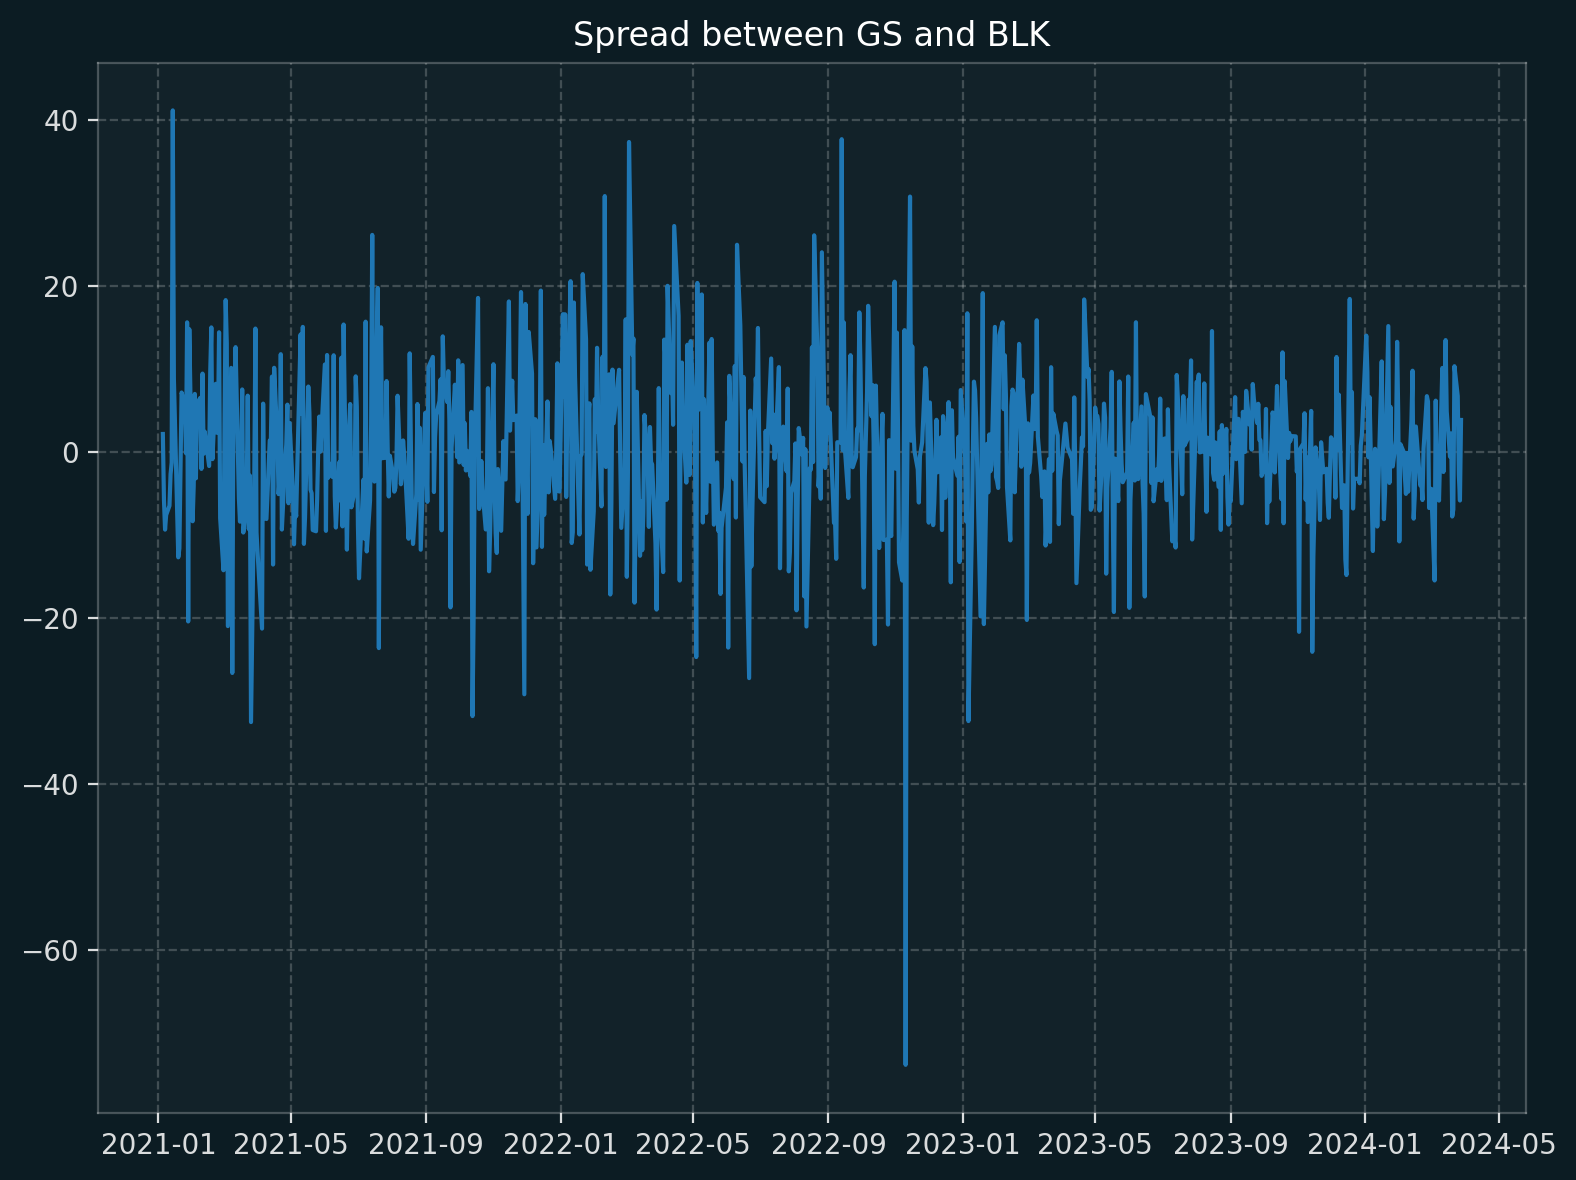

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(spread)
plt.title(f"Spread between {ticker_0} and {ticker_1}")
plt.show()

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_absolute_percentage_error

# Get the split date
split_date = pd.Timestamp.now() - DateOffset(months=6)

# Split the spread into a training set and a test set
train_spread = spread.loc[spread.index < split_date]
test_spread = spread.loc[spread.index >= split_date]

# Print the size of the training set and the test set
print("Training set size:", len(train_spread))
print("Test set size:", len(test_spread))

# Define the ARIMA model
model = ARIMA(train_spread, order=(5, 1, 0))

# Fit the model
model_fit = model.fit()

# Forecast the next 1, 5, and 15 time steps
forecast_1 = model_fit.forecast(steps=1)
forecast_5 = model_fit.forecast(steps=5)
forecast_15 = model_fit.forecast(steps=15)

# Print the forecasts
print("1 step forecast:", forecast_1)
print("5 steps forecast:", forecast_5)
print("15 steps forecast:", forecast_15)

# Evaluate the model on the test set
test_forecast = model_fit.forecast(steps=len(test_spread))
mape = mean_absolute_percentage_error(test_spread, test_forecast)

print(f"\nTest MAPE: {mape:.4f}")

Training set size: 693
Test set size: 120
1 step forecast: 693   -1.00703
dtype: float64
5 steps forecast: 693   -1.007030
694   -1.998350
695   -1.555069
696   -2.144456
697   -2.547525
Name: predicted_mean, dtype: float64
15 steps forecast: 693   -1.007030
694   -1.998350
695   -1.555069
696   -2.144456
697   -2.547525
698   -1.782596
699   -1.874795
700   -2.009967
701   -2.012005
702   -2.062938
703   -2.012307
704   -1.963373
705   -1.999476
706   -2.012750
707   -2.009986
Name: predicted_mean, dtype: float64

Test MAPE: 3.1425
